# Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.style.use("Solarize_Light2")

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LarsCV
from sklearn.linear_model import BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")

# Data overview

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/insurance/insurance.csv


In [3]:
data = pd.read_csv('/kaggle/input/insurance/insurance.csv')

In [4]:
data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [5]:
data.drop_duplicates(inplace=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


In [7]:
data.nunique()

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

In [8]:
data.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [9]:
numerical = ['age', 'bmi', 'children']
categorial = ['sex', 'smoker', 'region']
target = ['charges']

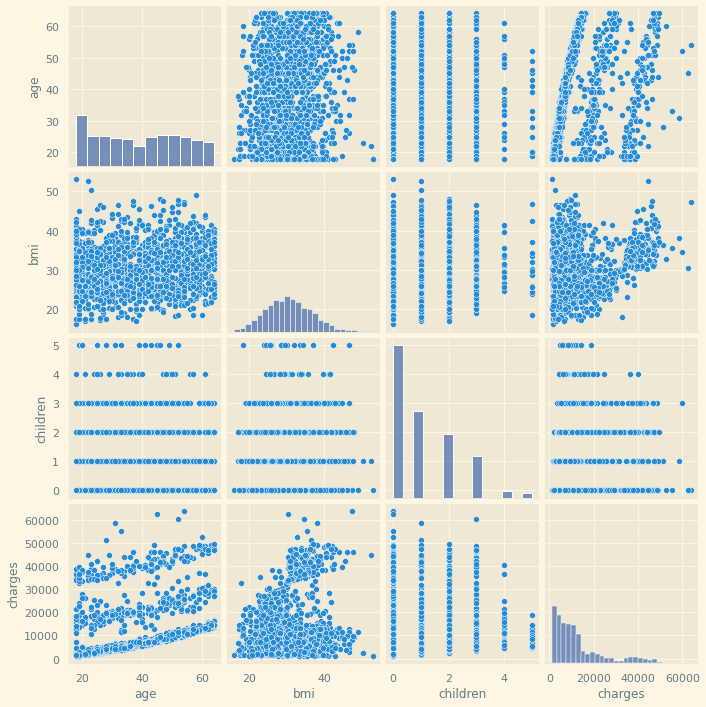

In [10]:
sns.pairplot(data[numerical + target])

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'bmi'}>],
       [<AxesSubplot:title={'center':'children'}>,
        <AxesSubplot:title={'center':'charges'}>]], dtype=object)

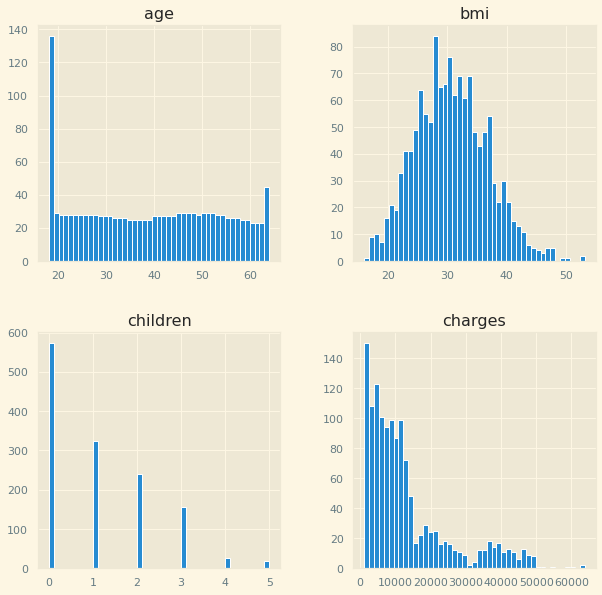

In [11]:
data[numerical + target].hist(bins=45, figsize=(10, 10))

**The bmi distribution is close to normal. We will logarithm the target attribute charges**

# Data preprocessing

## data.charges

<AxesSubplot:>

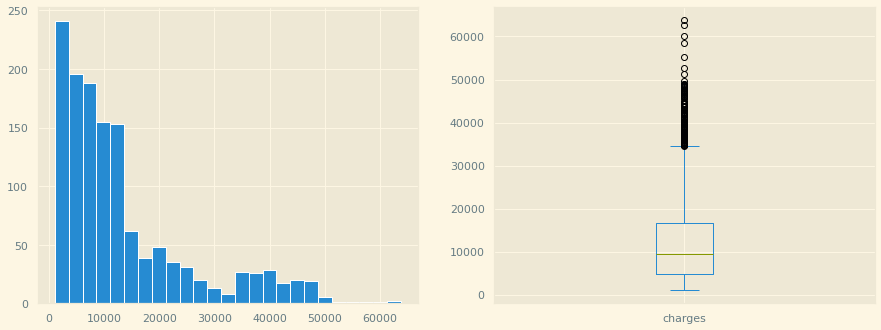

In [12]:
plt.figure(figsize=(15,12))
plt.subplot(2, 2, 1)
data.charges.hist(bins=25)
plt.subplot(2, 2, 2)
data.charges.plot.box()

In [13]:
data['log_charges'] = np.log(data['charges'])

<AxesSubplot:>

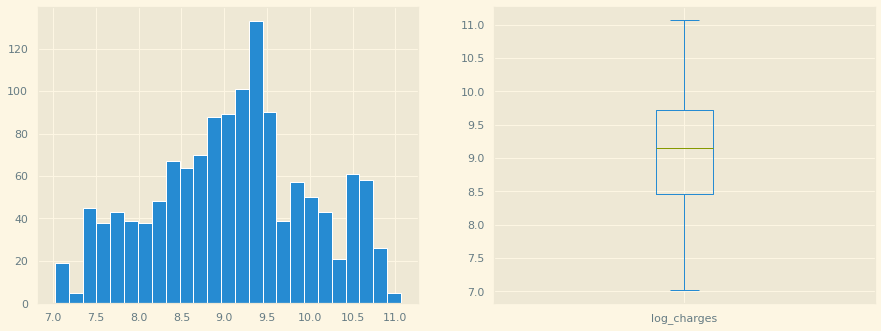

In [14]:
plt.figure(figsize=(15,12))
plt.subplot(2, 2, 1)
data.log_charges.hist(bins=25)
plt.subplot(2, 2, 2)
data.log_charges.plot.box()

In [15]:
data.head(3)

,age,sex,bmi,children,smoker,region,charges,log_charges
0,19,female,27.90,0,yes,southwest,16884.9240,9.734176
1,18,male,33.77,1,no,southeast,1725.5523,7.453302
2,28,male,33.00,3,no,southeast,4449.4620,8.400538


## data.smoker

<AxesSubplot:>

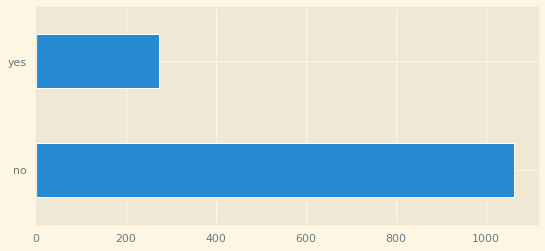

In [16]:
data.smoker.value_counts().plot.barh(figsize=(9, 4))

In [17]:
labelencoder = LabelEncoder()

In [18]:
data['smoker'] = labelencoder.fit_transform(data['smoker'])

**We encode it in 1 and 0**

In [19]:
data.groupby('smoker')['charges'].agg(['mean'])

,mean
smoker,
0,8440.660307
1,32050.231832


<AxesSubplot:xlabel='smoker'>

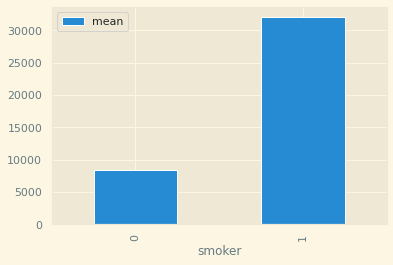

In [20]:
data.groupby('smoker')['charges'].agg(['mean']).reset_index().plot.bar(x='smoker')

**The smoker attribute has a very strong effect on the charges target variable.**

In [21]:
data.head(3)

,age,sex,bmi,children,smoker,region,charges,log_charges
0,19,female,27.90,0,1,southwest,16884.9240,9.734176
1,18,male,33.77,1,0,southeast,1725.5523,7.453302
2,28,male,33.00,3,0,southeast,4449.4620,8.400538


## data.age

<AxesSubplot:>

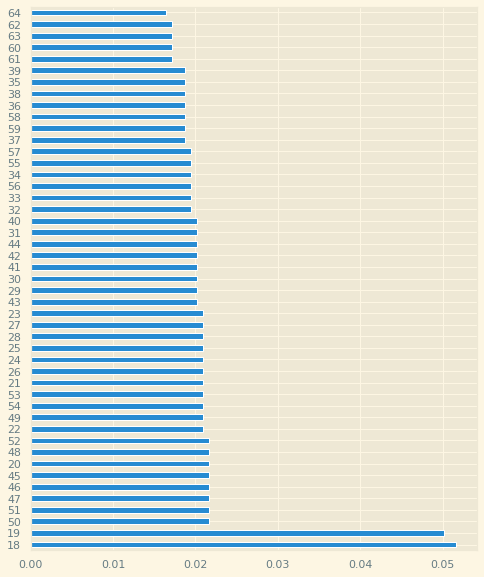

In [22]:
data['age'].value_counts(normalize=True).plot.barh(figsize=(8, 10))

**1% - age from 18 to 19 years**

<AxesSubplot:xlabel='age', ylabel='charges'>

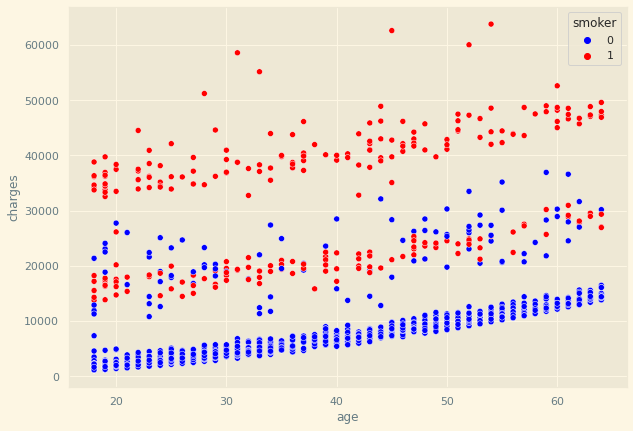

In [23]:
plt.figure(figsize=(10,7))
sns.scatterplot(x='age', y='charges', data=data, hue='smoker', palette=['blue','red'])

**The graph shows how the smoker variable correlates with age and charges**

In [24]:
data.head(3)

,age,sex,bmi,children,smoker,region,charges,log_charges
0,19,female,27.90,0,1,southwest,16884.9240,9.734176
1,18,male,33.77,1,0,southeast,1725.5523,7.453302
2,28,male,33.00,3,0,southeast,4449.4620,8.400538


## data.sex

<AxesSubplot:>

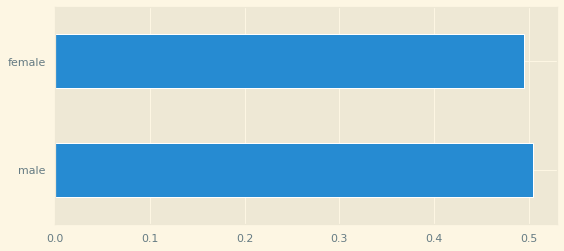

In [25]:
data.sex.value_counts(normalize=True).plot.barh(figsize=(9, 4))

In [26]:
data.groupby('sex').agg(['mean'])

,age,bmi,children,smoker,charges,log_charges
,mean,mean,mean,mean,mean,mean
sex,,,,,,
female,39.503021,30.377749,1.074018,0.173716,12569.578844,9.093428
male,38.946667,30.943652,1.117037,0.235556,13974.998864,9.106302


**Gender does not affect our data in any way. There are more smokers among men, so charges for men are a little more.**

<AxesSubplot:xlabel='sex', ylabel='charges'>

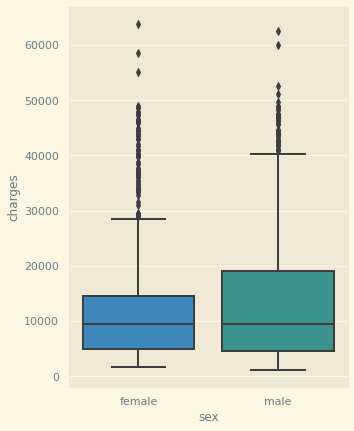

In [27]:
plt.figure(figsize=(5,7))
sns.boxplot(x='sex', y='charges', data=data)

**The average value of charges for male and female is the same, the range of values is wider for men, and narrower for women.**

In [28]:
data['sex'] = labelencoder.fit_transform(data['sex'])

In [29]:
data.sex.unique()

array([0, 1])

In [30]:
data.head(3)

,age,sex,bmi,children,smoker,region,charges,log_charges
0,19,0,27.90,0,1,southwest,16884.9240,9.734176
1,18,1,33.77,1,0,southeast,1725.5523,7.453302
2,28,1,33.00,3,0,southeast,4449.4620,8.400538


## data.region

<AxesSubplot:>

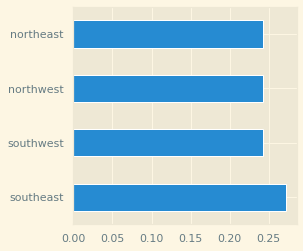

In [31]:
data['region'].value_counts(normalize=True).plot.barh(figsize=(4, 4))

In [32]:
data.groupby('region').agg('mean')

,age,sex,bmi,children,smoker,charges,log_charges
region,,,,,,,
northeast,39.268519,0.503086,29.173503,1.046296,0.206790,13406.384516,9.168768
northwest,39.259259,0.493827,29.195494,1.151235,0.179012,12450.840844,9.074880
southeast,38.939560,0.519231,33.355989,1.049451,0.250000,14735.411438,9.122402
southwest,39.455385,0.501538,30.596615,1.141538,0.178462,12346.937377,9.031098


**The values of the region variable are distributed equally**

In [33]:
data.groupby('region')[['smoker', 'charges']].agg('mean')

,smoker,charges
region,,
northeast,0.206790,13406.384516
northwest,0.179012,12450.840844
southeast,0.250000,14735.411438
southwest,0.178462,12346.937377


**charges are higher in northwest and southwest because the proportion of smokers there is higher**

In [34]:
data = pd.get_dummies(data, columns=['region'])

In [35]:
data.head(3)

,age,sex,bmi,children,smoker,charges,log_charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.90,0,1,16884.9240,9.734176,0,0,0,1
1,18,1,33.77,1,0,1725.5523,7.453302,0,0,1,0
2,28,1,33.00,3,0,4449.4620,8.400538,0,0,1,0


## data.children

<AxesSubplot:>

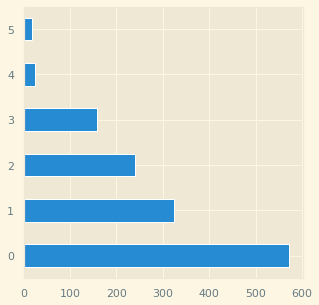

In [36]:
data['children'].value_counts().plot.barh(figsize=(5, 5))

In [37]:
data.groupby('children')[['smoker', 'charges']].agg('mean')

,smoker,charges
children,,
0,0.200698,12384.695344
1,0.188272,12731.171832
2,0.229167,15073.563734
3,0.248408,15355.318367
4,0.120000,13850.656311
5,0.055556,8786.035247


**According to the children variable, we also see the influence of smoker on the target variable charges**

## data.bmi

<AxesSubplot:>

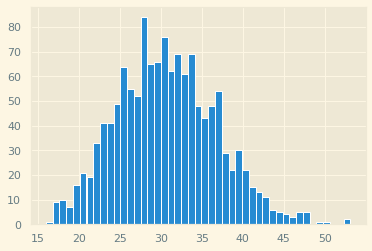

In [38]:
data.bmi.hist(bins=45)

<AxesSubplot:xlabel='bmi', ylabel='charges'>

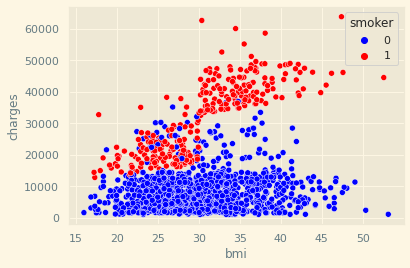

In [39]:
sns.scatterplot(x=data.bmi, y=data.charges, hue=data.smoker, palette=['blue','red'])

**For smokers, charges increase with an increase in bmi, non-smokers do not have such changes**

In [40]:
data['bmi_group'] = pd.cut(data['bmi'], (0, 16, 18.5, 25, 30, 35, 40, np.inf), labels=[1, 2, 3, 4, 5, 6, 7])

<AxesSubplot:xlabel='bmi', ylabel='charges'>

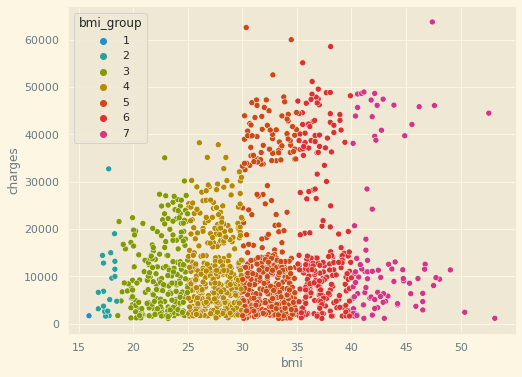

In [41]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=data.bmi, y=data.charges, hue=data.bmi_group)

**Let's create a new feature of bmi_group, where we interpret bmi: 1 - body weight deficit, 7 - obesity.**

In [42]:
data = pd.get_dummies(data, columns=['bmi_group'])

In [43]:
data.drop(['bmi'], axis=1, inplace=True)
numerical.remove('bmi')

In [44]:
data

,age,sex,children,smoker,charges,log_charges,region_northeast,region_northwest,region_southeast,region_southwest,bmi_group_1,bmi_group_2,bmi_group_3,bmi_group_4,bmi_group_5,bmi_group_6,bmi_group_7
0,19,0,0,1,16884.92400,9.734176,0,0,0,1,0,0,0,1,0,0,0
1,18,1,1,0,1725.55230,7.453302,0,0,1,0,0,0,0,0,1,0,0
2,28,1,3,0,4449.46200,8.400538,0,0,1,0,0,0,0,0,1,0,0
3,33,1,0,0,21984.47061,9.998092,0,1,0,0,0,0,1,0,0,0,0
4,32,1,0,0,3866.85520,8.260197,0,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,1,3,0,10600.54830,9.268661,0,1,0,0,0,0,0,0,1,0,0
1334,18,0,0,0,2205.98080,7.698927,1,0,0,0,0,0,0,0,1,0,0
1335,18,0,0,0,1629.83350,7.396233,0,0,1,0,0,0,0,0,0,1,0
1336,21,0,0,0,2007.94500,7.604867,0,0,0,1,0,0,0,1,0,0,0


# Split and scaled

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['charges', 'log_charges'], axis=1), 
    data['log_charges'],
    test_size=0.25, random_state=42
)

In [46]:
scaler = StandardScaler()

X_train_scaler = scaler.fit_transform(X_train[numerical])
X_test_scaler = scaler.transform(X_test[numerical])

X_train[numerical] = X_train_scaler
X_test[numerical] = X_test_scaler

In [47]:
X_train.head()

,age,sex,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest,bmi_group_1,bmi_group_2,bmi_group_3,bmi_group_4,bmi_group_5,bmi_group_6,bmi_group_7
763,-0.862948,1,-0.912228,0,1,0,0,0,0,0,0,1,0,0,0
1079,1.715175,1,1.596607,0,0,0,1,0,0,0,0,0,1,0,0
178,0.497728,0,0.760329,0,0,0,0,1,0,0,0,1,0,0,0
287,1.715175,0,-0.912228,0,0,1,0,0,0,0,0,1,0,0,0
1290,-0.075188,0,0.760329,0,1,0,0,0,0,0,1,0,0,0,0


In [48]:
len(X_train) + len(X_test) == len(data)

True

In [49]:
len(y_train) + len(y_test) == len(data)

True

# Training the model

In [50]:
#data_msg = pd.DataFrame(columns=['NAME', 'R2', 'MAE', 'RMSE', 'MAPE'])

In [51]:
def models_log(X_train, X_test, y_train, y_test):
    data_msg = pd.DataFrame(columns=['NAME', 'R2', 'MAE', 'RMSE', 'MAPE'])
    models = []
    models.append(('LR', LinearRegression()))
    models.append(('R', Ridge()))
    models.append(('L', Lasso()))
    models.append(('ELN', ElasticNet()))
    models.append(('LARS', LarsCV()))
    models.append(('BR', BayesianRidge(n_iter=1000)))
    models.append(('KNR', KNeighborsRegressor()))
    models.append(('DTR', DecisionTreeRegressor()))
    models.append(('LSVR', LinearSVR()))
    models.append(('SVR', SVR()))
    models.append(('ABR', AdaBoostRegressor(n_estimators=200)))
    models.append(('BR', BaggingRegressor(n_estimators=200)))
    models.append(('ETR', ExtraTreesRegressor(n_estimators=200)))
    models.append(('GBR', GradientBoostingRegressor(n_estimators=200)))
    models.append(('RFR', RandomForestRegressor(n_estimators=200)))
    models.append(('XGBR', XGBRegressor(n_estimators=200, eta=0.05, gamma=0.1)))
    names = []
    
    for name, model in models:
        model.fit(X_train, y_train)
        m_predict = model.predict(X_test)
        
        r2 = r2_score(np.exp(y_test), np.exp(m_predict)) # coefficient of determination-R2 score
        
        mae = mean_absolute_error(np.exp(y_test), np.exp(m_predict)) # mean absolute error
        
        rmse = np.sqrt(mean_absolute_error(np.exp(y_test), np.exp(m_predict))) # root mean squared error
        
        mape = np.mean(np.abs((np.exp(y_test) - np.exp(m_predict)) / np.exp(m_predict))) * 100 # mean absolute percentage error
        
        new_msg = {'NAME': name, 'R2': r2, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape}
        data_msg = data_msg.append(new_msg, ignore_index=True)
        
    return data_msg

In [52]:
models_log(X_train, X_test, y_train, y_test)

,NAME,R2,MAE,RMSE,MAPE
0,LR,0.725304,3680.657512,60.668423,31.859911
1,R,0.727329,3669.991075,60.580451,31.863713
2,L,-0.142203,8952.656721,94.618480,100.488088
3,ELN,-0.142203,8952.656721,94.618480,100.488088
4,LARS,0.725304,3680.657512,60.668423,31.859911
5,BR,0.727199,3670.546499,60.585035,31.863192
6,KNR,0.310532,5898.937334,76.804540,60.368274
7,DTR,0.778031,2976.143868,54.554045,26.685987
8,LSVR,0.637100,3858.879888,62.119883,31.603163
9,SVR,0.855071,2450.661953,49.504161,24.352702


**RFR, BR, TR, BR and SVR have the best results**

# RandomForestRegressor

In [53]:
RFR = RandomForestRegressor(n_estimators=300, criterion='mae', 
                                  max_depth=None, min_samples_split=8, min_samples_leaf=1, max_features='auto', 
                                  max_leaf_nodes=None, random_state=42) 
RFR_clf=RFR.fit(X_train, y_train)
RFR_predict = RFR.predict(X_test)
print('r2_score', r2_score(np.exp(y_test), np.exp(RFR_predict)))

r2_score 0.893052326544685


# GradientBoostingRegressor

In [54]:
XGBR = XGBRegressor(n_estimators = 200, eta=0.05, gamma=0.1, 
                    max_depth=4, min_child_weight=8, 
                    colsample_bytree=0.7, subsample=0.99)
XGBR.fit(X_train, y_train)
XGBR_predict = XGBR.predict(X_test)
print('r2_score', r2_score(np.exp(y_test), np.exp(XGBR_predict)))

r2_score 0.8912724547594644


# Visualization

In [55]:
RFR_diff = (-np.exp(y_test) + np.exp(RFR_predict))[:55]
XGBR_diff = (-np.exp(y_test) + np.exp(XGBR_predict))[:55]
y_test_diff = (y_test - y_test).head(55)

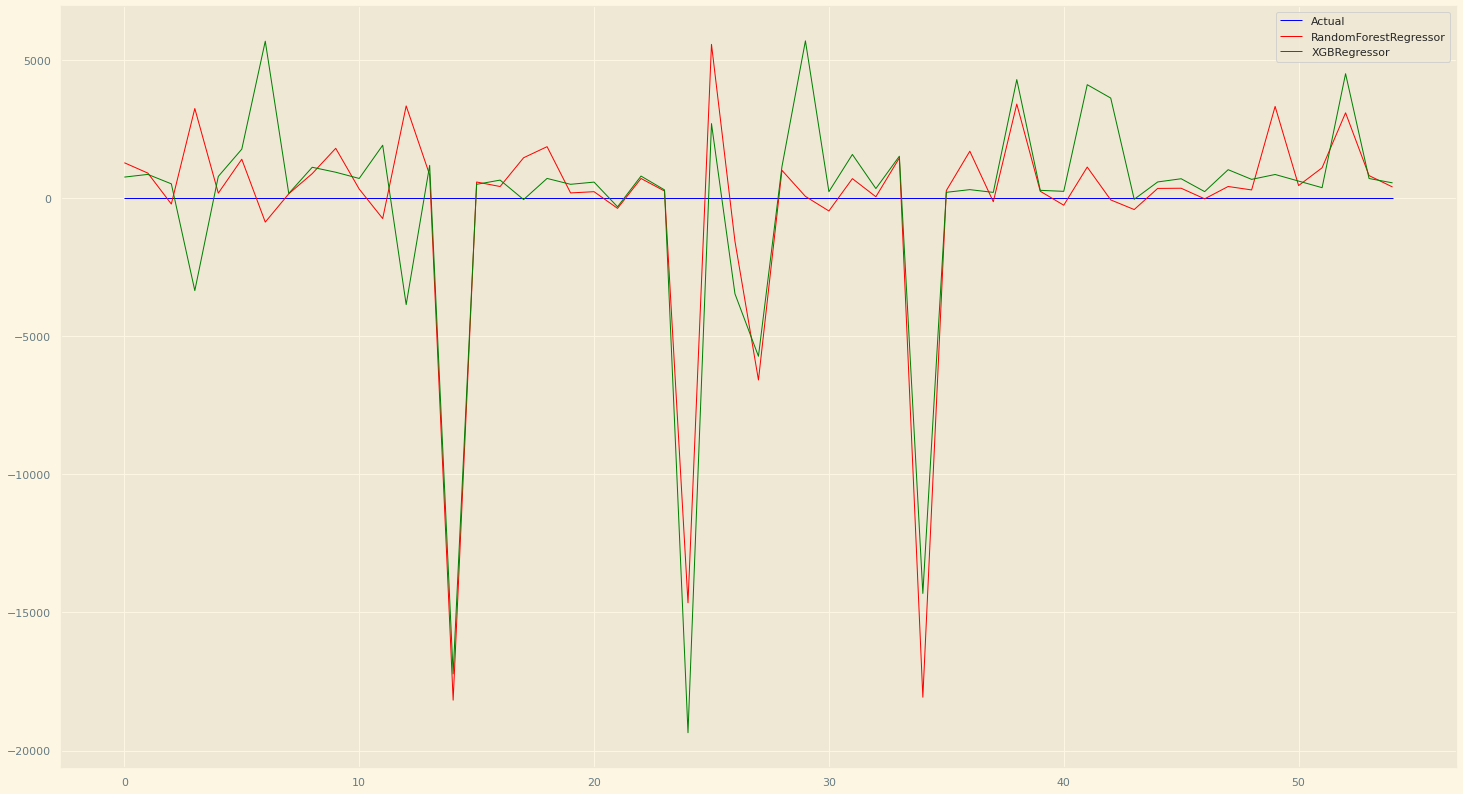

In [56]:
x_ax = range(len(np.exp(y_test_diff)))
plt.figure(figsize=(25,14))
plt.plot(x_ax, y_test_diff, lw=1, color="blue", label="Actual")
plt.plot(x_ax, RFR_diff, lw=1, color="red", label="RandomForestRegressor")
plt.plot(x_ax, XGBR_diff, lw=1, color="green", label="XGBRegressor")
plt.legend()
plt.show()

**Difference between the predicted and actual values on the example of 55 values**